In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import scipy.stats as stats
from scipy import stats
from scipy.special import inv_boxcox

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.postprocessing import ModelHandler


plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
#plt.rcParams.update({
 #       'font.family' : 'Times New Roman',
  #      'axes.titlesize' : 22,
   #     'axes.labelsize' : 22,
    #    'xtick.labelsize' : 20,
     #   'ytick.labelsize' : 20})

#labelsize = 22
#legendsize = 20
#test_size = 22
#titlesize = 24
#textsize = 18

In [3]:


def bootstrap_acf_random(series, n_lags, n_bootstrap=10000, sample_size = 1000):
    acf_vals = []
    pacf_vals = []
    
    lower_acf_all = []
    higher_acf_all = []
    lower_pacf_all = []
    higher_pacf_all = []
    
    chunk_size = 10000
    chuncks = [series[i:i + chunk_size] for i in range(0, len(series), chunk_size)]
    print(len(chuncks[0]))
    
    for _ in range(n_bootstrap):
        random_int = np.random.randint(1,len(series)-sample_size)
        resampled_series = series[random_int:random_int+sample_size]
        acf_values, conf_acf = acf(resampled_series, nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(resampled_series, nlags=n_lags, alpha = 0.05)
        
        lower_acf = conf_acf[:,0] - acf_values
        higher_acf = conf_acf[:,1] - acf_values
        
        lower_pacf = conf_pacf[:,0] - pacf_values
        higher_pacf = conf_pacf[:,1] - pacf_values
        
        acf_vals.append(acf_values)
        pacf_vals.append(pacf_values)
        lower_acf_all.append(lower_acf)
        higher_acf_all.append(higher_acf)
        lower_pacf_all.append(lower_pacf)
        higher_pacf_all.append(higher_pacf)        
        

    acf_vals = np.array(acf_vals)
    pacf_vals = np.asarray(pacf_vals)
    lower_acf_all = np.asarray(lower_acf_all)
    higher_acf_all = np.asarray(higher_acf_all)
    lower_pacf_all = np.asarray(lower_pacf_all)
    higher_pacf_all = np.asarray(higher_pacf_all)

    stacked_array = np.stack(acf_vals)
    acf_vals = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(pacf_vals)
    pacf_vals = np.mean(stacked_array, axis=0)    

    stacked_array = np.stack(lower_acf_all)
    lower_acf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_acf_all)
    higher_acf_all = np.mean(stacked_array, axis=0)

    stacked_array = np.stack(lower_pacf_all)
    lower_pacf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_pacf_all)
    higher_pacf_all = np.mean(stacked_array, axis=0)   

    return acf_vals, pacf_vals, lower_acf_all, higher_acf_all, lower_pacf_all, higher_pacf_all

def bootstrap_acf(series, n_lags, n_bootstrap=10000, sample_size = 1000):
    acf_vals = []
    pacf_vals = []
    
    lower_acf_all = []
    higher_acf_all = []
    lower_pacf_all = []
    higher_pacf_all = []
    
    chuncks = [series[i:i + sample_size] for i in range(0, len(series), sample_size)]
    
    for chunck in chuncks:
        acf_values, conf_acf = acf(chunck, nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(chunck, nlags=n_lags, alpha = 0.05)
        
        lower_acf = conf_acf[:,0] - acf_values
        higher_acf = conf_acf[:,1] - acf_values
        
        lower_pacf = conf_pacf[:,0] - pacf_values
        higher_pacf = conf_pacf[:,1] - pacf_values
        
        acf_vals.append(acf_values)
        pacf_vals.append(pacf_values)
        lower_acf_all.append(lower_acf)
        higher_acf_all.append(higher_acf)
        lower_pacf_all.append(lower_pacf)
        higher_pacf_all.append(higher_pacf)        
        
    acf_vals = np.array(acf_vals)
    pacf_vals = np.asarray(pacf_vals)
    lower_acf_all = np.asarray(lower_acf_all)
    higher_acf_all = np.asarray(higher_acf_all)
    lower_pacf_all = np.asarray(lower_pacf_all)
    higher_pacf_all = np.asarray(higher_pacf_all)

    stacked_array = np.stack(acf_vals)
    acf_vals = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(pacf_vals)
    pacf_vals = np.mean(stacked_array, axis=0)    

    stacked_array = np.stack(lower_acf_all)
    lower_acf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_acf_all)
    higher_acf_all = np.mean(stacked_array, axis=0)

    stacked_array = np.stack(lower_pacf_all)
    lower_pacf_all = np.mean(stacked_array, axis=0)
    stacked_array = np.stack(higher_pacf_all)
    higher_pacf_all = np.mean(stacked_array, axis=0)   

    return acf_vals, pacf_vals, lower_acf_all, higher_acf_all, lower_pacf_all, higher_pacf_all

In [4]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [5]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "black",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
              r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
              ls = "-",
              )
     }

arima
elstm / 100000
dictonary loaded
35/35 [==============================] - 1s 9ms/step
pbhm-hlstm0000
dictonary loaded
35/35 [==============================] - 1s 11ms/step


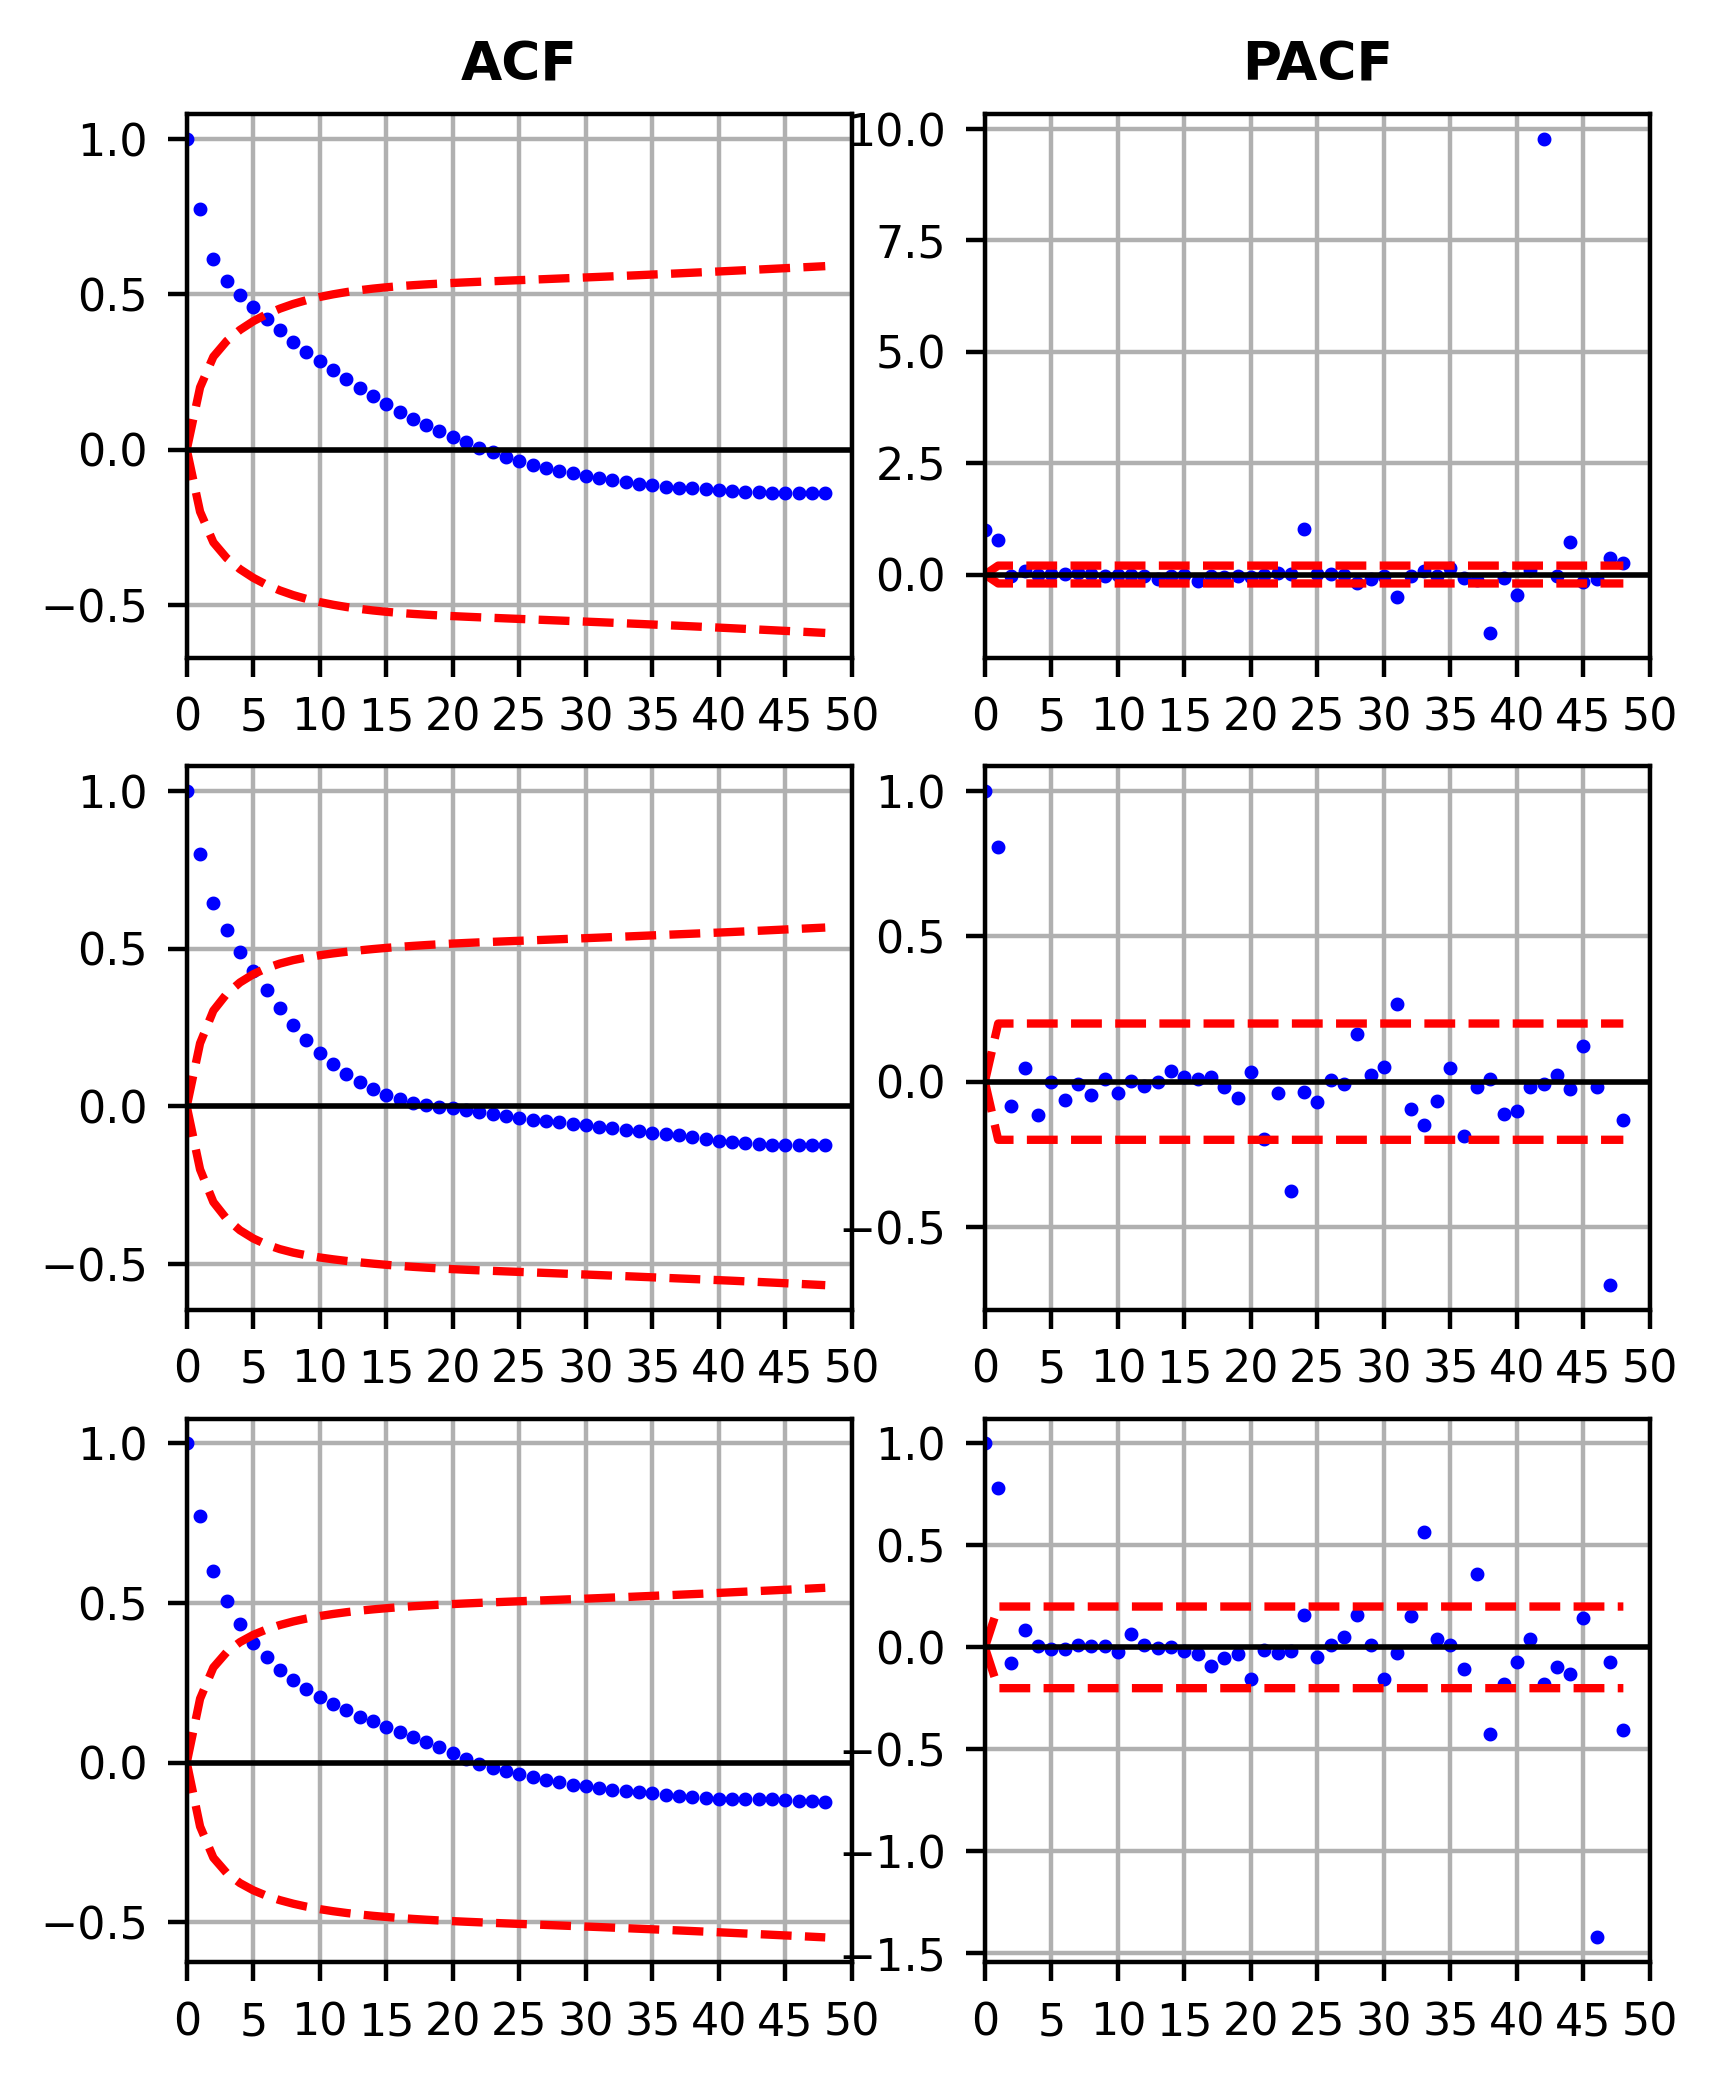

In [27]:
idx = -10
n_lags = 48

fig, axes = plt.subplots(3,2,figsize=(4.72,6), dpi=400)

for n, key in enumerate(models.keys()):
    idx += 10
    print(key)

    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

    res = np.ndarray(shape=(0,96))
    for n_fold in range(5):
        year = 2013 + n_fold
        if models[key].is_external_model:
            # load external which come already with observations
            ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

            # get external model observations
            y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

            # get external model predictions
            yp = ext_df.filter(like="fc").values
                        
        else:
            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

           # if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
              #  yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
           # else:
            # load model
            tf.keras.backend.clear_session()
            model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

            # model prediction
            yp = model.predict(X, batch_size=1000)

        # check for normal distribution 
        a=o
        res = np.append(res, yp-y[:,:,0], axis=0)

    df = pd.DataFrame(columns = ["acf", "pacf", "lower_acf", "higher_acf", "lower_pacf", "higher_pacf"],
                  index=pd.MultiIndex(levels=[[],[]],codes=[[],[]], names=["lead_time", "lag"]))

    #df_diff = df.copy()

    n_samples        = res.shape[0]
    n_random_samples = 100000
    rst_acf, rst_pacf = np.zeros((49)), np.zeros((49))
    rst_acf_conf, rst_pacf_conf = np.zeros((49,2)), np.zeros((49,2))
    for m in range(n_random_samples):
        residuals = res[np.random.randint(0,n_samples-1),:]
        acf_values,  conf_acf  = acf(residuals,  nlags=n_lags, fft=True, alpha = 0.05)
        pacf_values, conf_pacf = pacf(residuals, nlags=n_lags, alpha = 0.05)
        rst_acf  += acf_values  / n_random_samples
        rst_pacf += pacf_values / n_random_samples
        rst_acf_conf  += (conf_acf - np.array([acf_values, acf_values]).T)   / n_random_samples
        rst_pacf_conf += (conf_pacf- np.array([pacf_values, pacf_values]).T) / n_random_samples

        
        if m%1000 == 0:
            print(f"{m+1} / {n_random_samples}", end="\r")

        
        #rst_diff = bootstrap_acf(np.diff(residuals), n_lags=n_lags, sample_size = 4000)
    
    axes[n,0].plot(np.arange(49), rst_acf,   marker=".", color="b", ls="None", markersize=3)
    axes[n,1].plot(np.arange(49), rst_pacf,  marker=".", color="b", ls="None", markersize=3)
    
    axes[n,0].plot(np.arange(49), rst_acf_conf[:,0],   color="r", ls="--")
    axes[n,0].plot(np.arange(49), rst_acf_conf[:,1],   color="r", ls="--")
    axes[n,1].plot(np.arange(49), rst_pacf_conf[:,0],  color="r", ls="--")
    axes[n,1].plot(np.arange(49), rst_pacf_conf[:,1],  color="r", ls="--")

    
       # for k in range(n_lags):
           # df.loc[(m, k), df.columns] = [x[k] for x in rst]
            #df_diff.loc[(m, k), df.columns] = [x[k] for x in rst_diff]

   # for m in range(n_lags):
        #axes[n,0].plot(m+1, df.acf.xs(m, level=1).values[0],  marker=".", color="g", ls="None", markersize=3)
       # axes[n,0].plot(m+1, df.acf.xs(m, level=1).values[95], marker="x", color="g", ls="None", markersize=3)
       # arrow_base   = df.acf.xs(m, level=1).values[0]
        #arrow_length = df.acf.xs(m, level=1).values[95] - arrow_base
       # if np.abs(arrow_length) > 0.05:
         #   arrow_0 = axes[n,0].arrow(m+1, arrow_base, 0, arrow_length, color="g", length_includes_head=True, width=0.025, head_length=0.05, head_width=0.5)

        
       # axes[n,1].plot(m+1, df.pacf.xs(m, level=1).values[0],  marker=".", color="g", ls="None", markersize=3)
       # axes[n,1].plot(m+1, df.pacf.xs(m, level=1).values[95], marker="x", color="g", ls="None", markersize=3)
       # arrow_base   = df.pacf.xs(m, level=1).values[0]
        #arrow_length = df.pacf.xs(m, level=1).values[95] - arrow_base
        #if np.abs(arrow_length) > 0.05:
          #  axes[n,1].arrow(m+1, arrow_base, 0, arrow_length, color="g", length_includes_head=True, width=0.025, head_length=0.07, head_width=0.5)
        
       # axes[n,0].plot(m+1, df_diff.acf.xs(m, level=1).values[0],  marker=".", color="b", ls="None", markersize=3)
        #axes[n,0].plot(m+1, df_diff.acf.xs(m, level=1).values[95], marker="x", color="b", ls="None", markersize=3)
        #arrow_base   = df_diff.acf.xs(m, level=1).values[0]
        #arrow_length = df_diff.acf.xs(m, level=1).values[95] - arrow_base
        #if np.abs(arrow_length) > 0.05:
         #   arrow_1 = axes[n,0].arrow(m+1, arrow_base, 0, arrow_length, color="b", length_includes_head=True, width=0.025, head_length=0.05, head_width=0.5)

        
        #axes[n,1].plot(m+1, df_diff.pacf.xs(m, level=1).values[0],  marker=".", color="b", ls="None", markersize=3)
        #axes[n,1].plot(m+1, df_diff.pacf.xs(m, level=1).values[95], marker="x", color="b", ls="None", markersize=3)
        #arrow_base   = df_diff.pacf.xs(m, level=1).values[0]
        #arrow_length = df_diff.pacf.xs(m, level=1).values[95] - arrow_base
        #if np.abs(arrow_length) > 0.05:
         #   axes[n,1].arrow(m+1, arrow_base, 0, arrow_length, color="b", length_includes_head=True, width=0.025, head_length=0.05, head_width=0.5)

    #axes[n,0].plot(np.arange(1,26,1), df.lower_acf.xs(0, level=0).values, color="r", ls="--")
    #axes[n,0].plot(np.arange(1,26,1), df.lower_acf.xs(95, level=0).values, color="r", ls="-")
    #axes[n,1].plot(np.arange(1,26,1), df.lower_pacf.xs(0, level=0).values, color="r", ls="--")
    #axes[n,1].plot(np.arange(1,26,1), df.lower_pacf.xs(95, level=0).values, color="r", ls="-")
    #axes[n,0].plot(np.arange(1,26,1), df.higher_acf.xs(0, level=0).values, color="r", ls="--")
    #axes[n,0].plot(np.arange(1,26,1), df.higher_acf.xs(95, level=0).values, color="r", ls="-")
    #axes[n,1].plot(np.arange(1,26,1), df.higher_pacf.xs(0, level=0).values, color="r", ls="--")
    #axes[n,1].plot(np.arange(1,26,1), df.higher_pacf.xs(95, level=0).values, color="r", ls="-")

    axes[0,0].set_title("ACF", fontweight="bold")
    axes[0,1].set_title("PACF", fontweight="bold")
    
    for m in range(2):
        axes[n,m].grid()
        axes[n,m].axhline(y = 0.0, color = 'k', lw=1)
        axes[n,m].set_xlim((0,48))
        #axes[n,m].set_ylim((-0.5,1.05))
        axes[n,m].set_xticks(np.arange(0,55,5))
        #axes[n,m].text(n_lags-2, 0.9, key, ha="right", fontweight="bold")
   # axes[n,1].set_ylim((-0.1,1.05))
        
#fig.tight_layout()
#axes[0,1].legend([arrow_0, arrow_1], ["residuals","residuals - differentiated"],
         #       bbox_to_anchor=(-0.15, 1.25), 
             #   loc='lower center', ncol=3, 
          #      borderaxespad=0)


In [1]:
fig.savefig(os.path.join(PLOT_PATH, 'ACF_PACF-leadtime-new-50k-t.png'), dpi=300, bbox_inches='tight')

NameError: name 'fig' is not defined